In [7]:
import glob
import os

import cv2
import numpy as np
import torch
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn.functional as F


def as_intrinsics_matrix(intrinsics):
    """
    Get matrix representation of intrinsics.

    """
    K = np.eye(3)
    K[0, 0] = intrinsics[0]
    K[1, 1] = intrinsics[1]
    K[0, 2] = intrinsics[2]
    K[1, 2] = intrinsics[3]
    return K

from torch.utils.data import Dataset


def readEXR_onlydepth(filename):
    """
    Read depth data from EXR image file.

    Args:
        filename (str): File path.

    Returns:
        Y (numpy.array): Depth buffer in float32 format.
    """
    # move the import here since only CoFusion needs these package
    # sometimes installation of openexr is hard, you can run all other datasets
    # even without openexr
    import Imath
    import OpenEXR as exr

    exrfile = exr.InputFile(filename)
    header = exrfile.header()
    dw = header["dataWindow"]
    isize = (dw.max.y - dw.min.y + 1, dw.max.x - dw.min.x + 1)

    channelData = dict()

    for c in header["channels"]:
        C = exrfile.channel(c, Imath.PixelType(Imath.PixelType.FLOAT))
        C = np.fromstring(C, dtype=np.float32)
        C = np.reshape(C, isize)

        channelData[c] = C

    Y = None if "Y" not in header["channels"] else channelData["Y"]

    return Y


def get_dataset(cfg, args, scale, device="cuda:0"):
    return dataset_dict[cfg["dataset"]](cfg, args, scale, device=device)


class BaseDataset(Dataset):
    def __init__(self, cfg, args, scale, device="cuda:0"):
        super(BaseDataset, self).__init__()

        self.name = cfg["dataset"]

        # -------------------added-----------------------------------------------
        if self.name == "replica":
            self.output_dimension_semantic = cfg["output_dimension_semantic"]
        # ------------------end-added-----------------------------------------------

        self.device = device
        self.scale = scale
        self.png_depth_scale = cfg["cam"]["png_depth_scale"]

        self.H, self.W, self.fx, self.fy, self.cx, self.cy = (
            cfg["cam"]["H"],
            cfg["cam"]["W"],
            cfg["cam"]["fx"],
            cfg["cam"]["fy"],
            cfg["cam"]["cx"],
            cfg["cam"]["cy"],
        )

        self.distortion = (
            np.array(cfg["cam"]["distortion"]) if "distortion" in cfg["cam"] else None
        )
        self.crop_size = cfg["cam"]["crop_size"] if "crop_size" in cfg["cam"] else None

        if args.input_folder is None:
            self.input_folder = cfg["data"]["input_folder"]
        else:
            self.input_folder = args.input_folder

        self.crop_edge = cfg["cam"]["crop_edge"]

    def __len__(self):
        return self.n_img

    def __getitem__(self, index):
        color_path = self.color_paths[index]
        depth_path = self.depth_paths[index]
        color_data = cv2.imread(color_path)
        # -------------------added-----------------------------------------------
        semantic_path = self.semantic_paths[index]
        semantic_data = np.load(semantic_path).astype(
            bool
        )  # TODO probably change later to actual semantic data
        # -----------------end--added-----------------------------------------------
        if ".png" in depth_path:
            depth_data = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        elif ".exr" in depth_path:
            depth_data = readEXR_onlydepth(depth_path)
        if (
            self.distortion is not None
        ):  # TODO should distorion be applied to semantics?
            K = as_intrinsics_matrix([self.fx, self.fy, self.cx, self.cy])
            # undistortion is only applied on color image, not depth!
            color_data = cv2.undistort(color_data, K, self.distortion)

        color_data = cv2.cvtColor(
            color_data, cv2.COLOR_BGR2RGB
        )  # J: convertion BGR -> RGB
        color_data = color_data / 255.0
        depth_data = depth_data.astype(np.float32) / self.png_depth_scale
        H, W = depth_data.shape
        # -------------------added-----------------------------------------------
        # semantic_data = semantic_data.resize((H, W, self.output_dimension_semantic)) #TODO check if this works
        # ------------------end-added-----------------------------------------------
        color_data = cv2.resize(
            color_data, (W, H)
        )  # shape after (680, 1200, 3) = (H, W, 3)
        color_data = torch.from_numpy(color_data)
        depth_data = torch.from_numpy(depth_data) * self.scale
        # -------------------added-----------------------------------------------
        semantic_data = torch.from_numpy(semantic_data)
        # ------------------end-added-----------------------------------------------
        if (
            self.crop_size is not None
        ):  # TODO check if we ever use this, if yes add to semantic (maybe use assert(...))
            # follow the pre-processing step in lietorch, actually is resize
            assert False, "crop_size is not None -> need to crop semantic data"
            color_data = color_data.permute(2, 0, 1)
            color_data = F.interpolate(
                color_data[None], self.crop_size, mode="bilinear", align_corners=True
            )[0]
            depth_data = F.interpolate(
                depth_data[None, None], self.crop_size, mode="nearest"
            )[0, 0]
            color_data = color_data.permute(1, 2, 0).contiguous()

        edge = self.crop_edge
        if edge > 0:
            # crop image edge, there are invalid value on the edge of the color image
            color_data = color_data[edge:-edge, edge:-edge]
            depth_data = depth_data[edge:-edge, edge:-edge]
            # -------------------added-----------------------------------------------
            semantic_data = semantic_data[edge:-edge, edge:-edge]
            # ------------------end-added-----------------------------------------------
        pose = self.poses[index]
        pose[:3, 3] *= self.scale
        return (
            index,
            color_data.to(self.device),
            depth_data.to(self.device),
            pose.to(self.device),
            semantic_data.to(self.device),
        )  # Done: add return semantics


class Replica(BaseDataset):
    def __init__(self, cfg, args, scale, device="cuda:0"):
        super(Replica, self).__init__(cfg, args, scale, device)
        self.color_paths = sorted(glob.glob(f"{self.input_folder}/results/frame*.jpg"))
        self.depth_paths = sorted(glob.glob(f"{self.input_folder}/results/depth*.png"))
        # -------------------added-----------------------------------------------
        self.semantic_paths = sorted(
            glob.glob(f"{self.input_folder}/results/semantic*.npy")
        )
        # -------------------end added-----------------------------------------------
        self.n_img = len(self.color_paths)
        self.load_poses(f"{self.input_folder}/traj.txt")

    def load_poses(self, path):
        self.poses = []
        with open(path, "r") as f:
            lines = f.readlines()
        for i in range(self.n_img):
            line = lines[i]
            c2w = np.array(list(map(float, line.split()))).reshape(4, 4)
            c2w[:3, 1] *= -1
            c2w[:3, 2] *= -1
            c2w = torch.from_numpy(c2w).float()
            self.poses.append(c2w)

In [17]:
import yaml


def load_config(path, default_path=None):
    """
    Loads config file.

    Args:
        path (str): path to config file.
        default_path (str, optional): whether to use default path. Defaults to None.

    Returns:
        cfg (dict): config dict.

    """
    # load configuration from file itself
    with open(path, "r") as f:
        cfg_special = yaml.full_load(f)

    # check if we should inherit from a config
    inherit_from = cfg_special.get("inherit_from")

    # if yes, load this config first as default
    # if no, use the default_path
    if inherit_from is not None:
        cfg = load_config(inherit_from, default_path)
    elif default_path is not None:
        with open(default_path, "r") as f:
            cfg = yaml.full_load(f)
    else:
        cfg = dict()

    # include main configuration
    update_recursive(cfg, cfg_special)

    return cfg


def update_recursive(dict1, dict2):
    """
    Update two config dictionaries recursively.

    Args:
        dict1 (dict): first dictionary to be updated.
        dict2 (dict): second dictionary which entries should be used.
    """
    for k, v in dict2.items():
        if k not in dict1:
            dict1[k] = dict()
        if isinstance(v, dict):
            update_recursive(dict1[k], v)
        else:
            dict1[k] = v

In [14]:
dataset_dict = {
    "replica": Replica,
}

In [19]:
cfg = load_config(
    "/Users/A200254469/Desktop/tum/2024ws/advancedDL4CV/segment/nice-slam/configs/Replica/room0_test.yaml"
)
print(cfg)

{'dataset': 'replica', 'meshing': {'eval_rec': True}, 'tracking': {'vis_freq': 50, 'vis_inside_freq': 25, 'ignore_edge_W': 100, 'ignore_edge_H': 100, 'seperate_LR': False, 'const_speed_assumption': True, 'lr': 0.001, 'pixels': 200, 'iters': 10}, 'mapping': {'every_frame': 5, 'vis_freq': 50, 'vis_inside_freq': 30, 'mesh_freq': 50, 'ckpt_freq': 500, 'keyframe_every': 50, 'mapping_window_size': 5, 'pixels': 1000, 'iters_first': 1500, 'iters': 60, 'bound': [[-2.9, 8.9], [-3.2, 5.5], [-3.5, 3.3]], 'marching_cubes_bound': [[-2.9, 8.9], [-3.2, 5.5], [-3.5, 3.3]]}, 'cam': {'H': 680, 'W': 1200, 'fx': 600.0, 'fy': 600.0, 'cx': 599.5, 'cy': 339.5, 'png_depth_scale': 6553.5, 'crop_edge': 0}, 'inherit_from': '/Users/A200254469/Desktop/tum/2024ws/advancedDL4CV/segment/nice-slam/configs/Replica/replica.yaml', 'data': {'input_folder': 'Datasets/Replica/room0', 'output': 'output/Replica/room0'}}


In [3]:
path_to_traj = "/Users/A200254469/Desktop/tum/2024ws/advancedDL4CV/segment/nice-slam/Datasets/Replica/room0/traj.txt"
path_to_frames = "/Users/A200254469/Desktop/tum/2024ws/advancedDL4CV/segment/nice-slam/Datasets/Replica/room0/results"
import numpy as np
# caution: path[0] is reserved for script path (or '' in REPL)

T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)
print(T_wc.shape)

(2000, 4, 4)


# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = False

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [ ]:
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

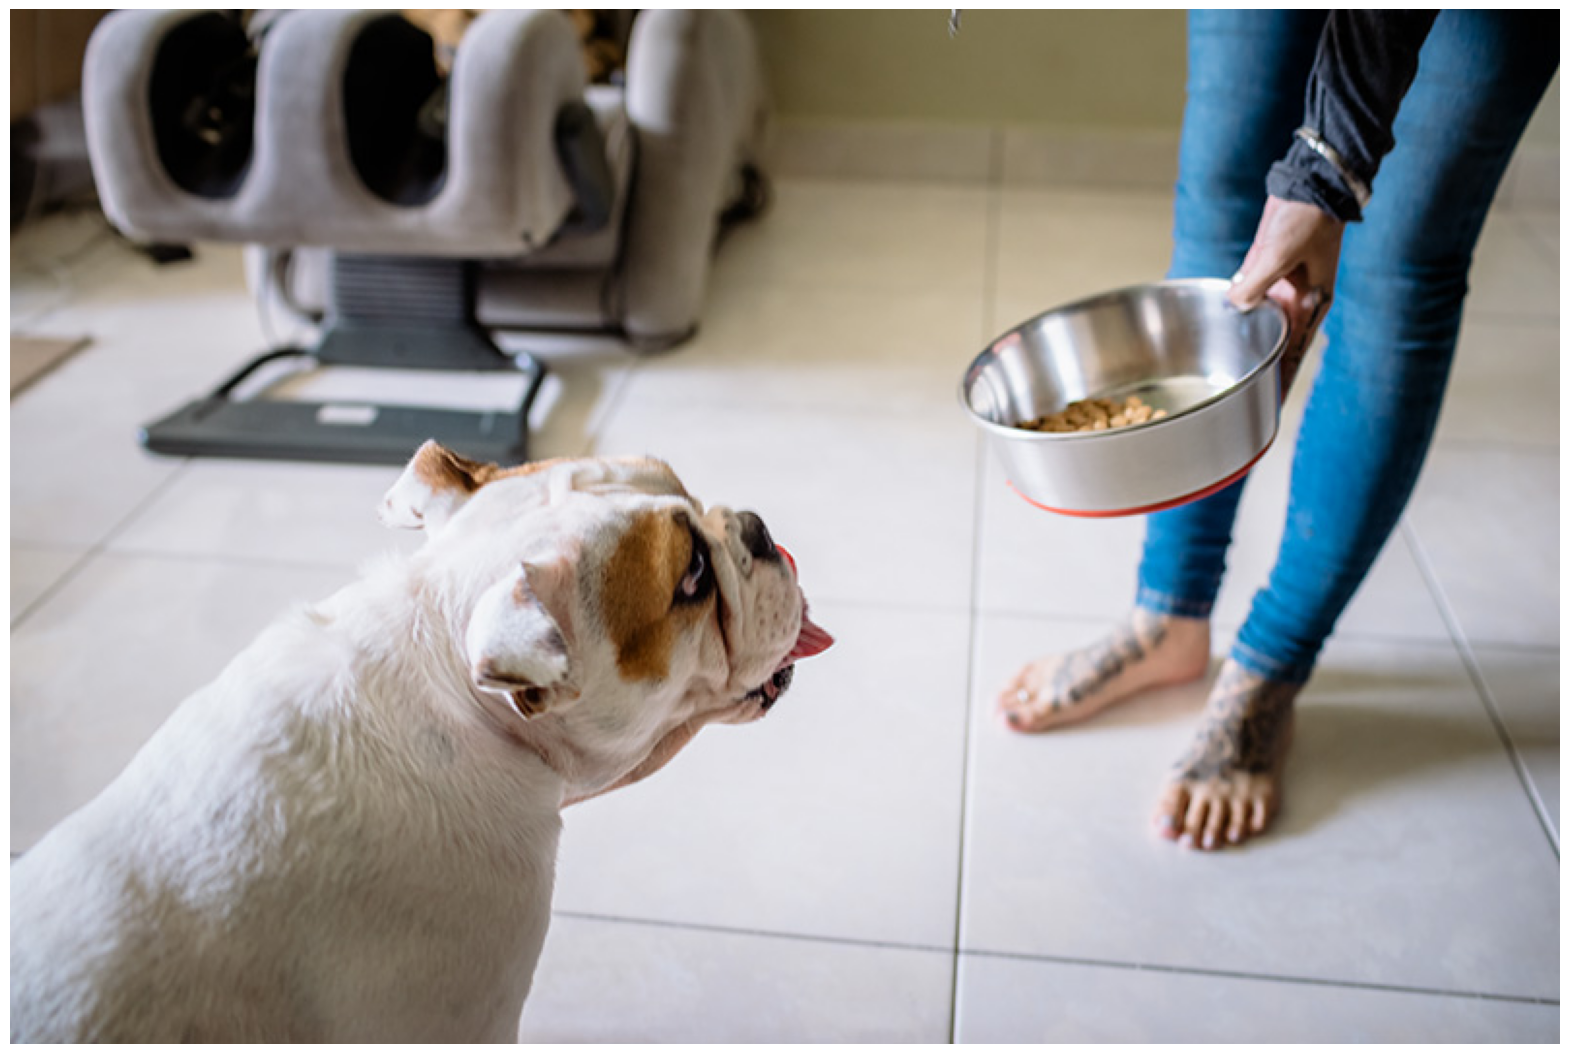

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys

sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/Users/A200254469/Desktop/tum/2024ws/advancedDL4CV/segment/nice-slam/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [ ]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

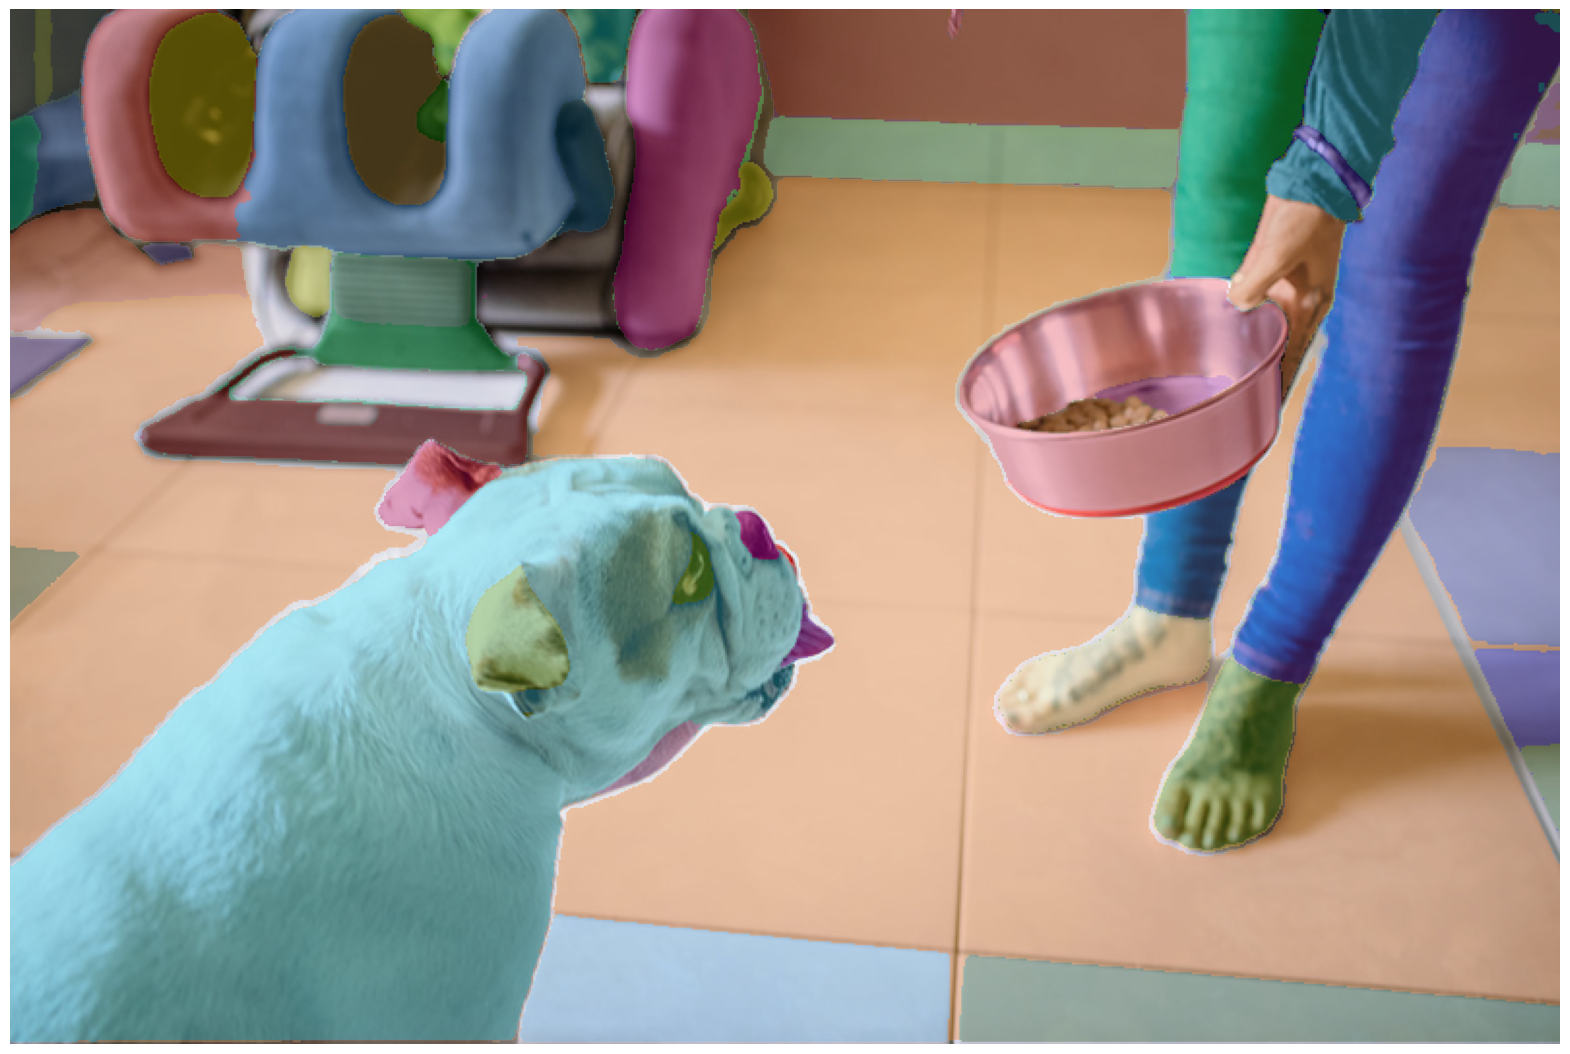

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

90

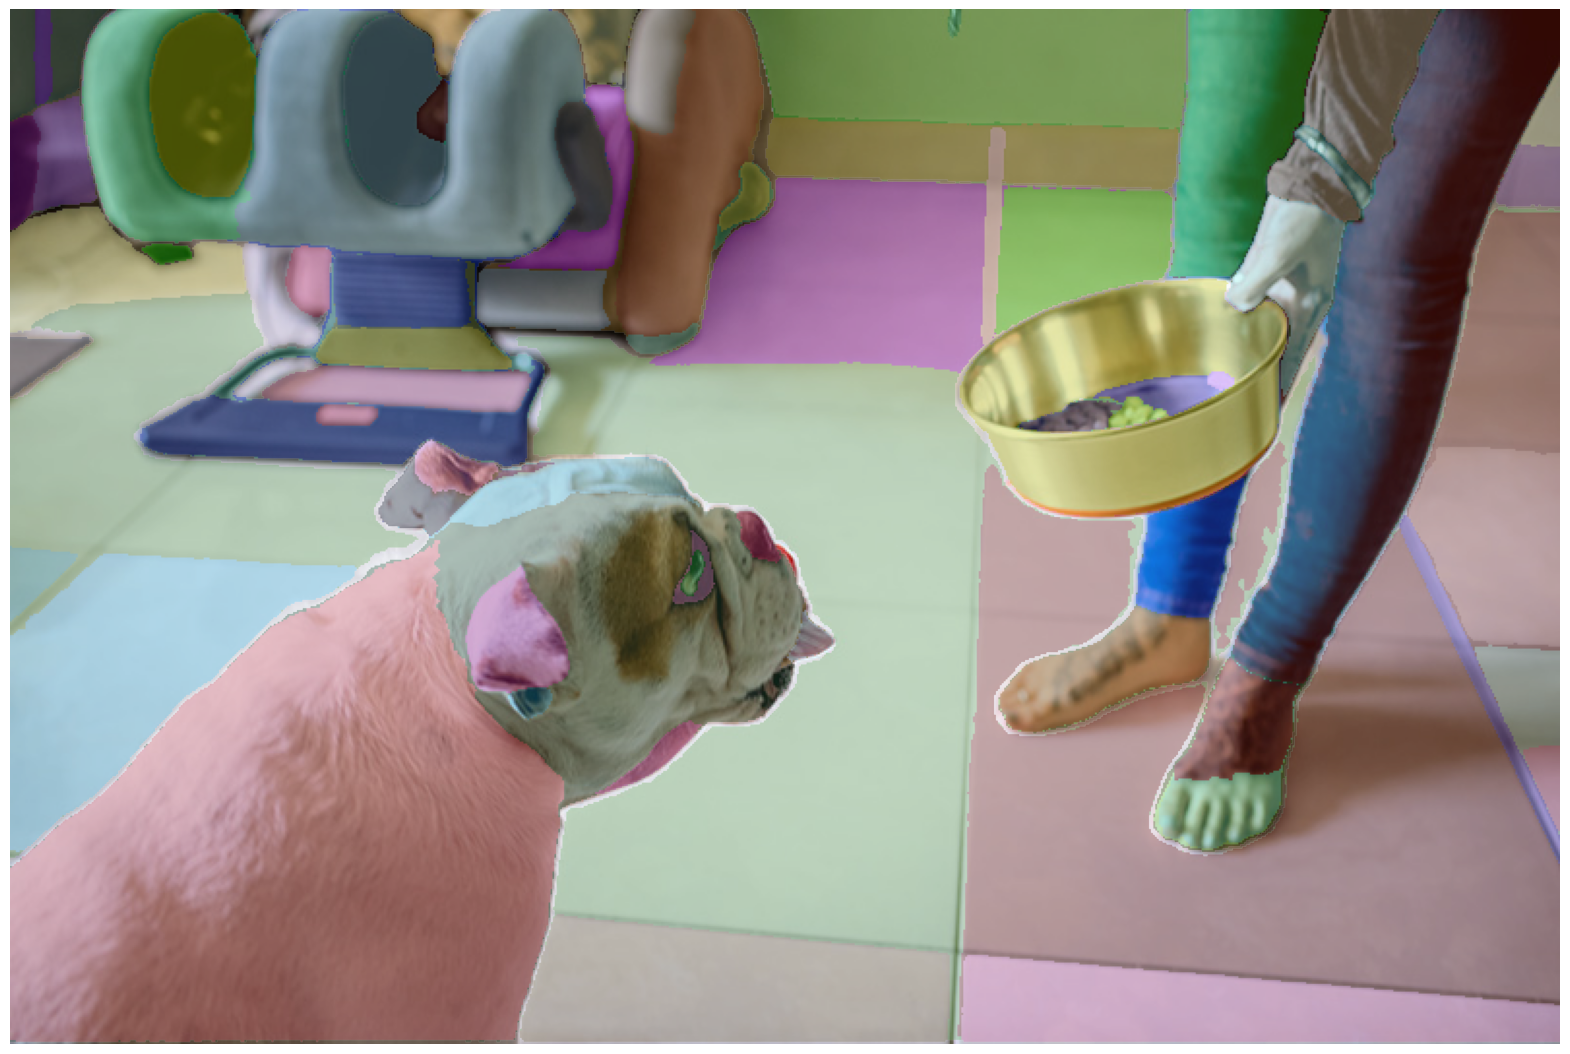

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 